## Cookie Cats 
is a popular mobile game developed by Tactile Entertainement, which features singing cats. Not my cup of tea but it serves well as case for an AB test exercise with Bootstrap.
Going through the game, a player, will encounter gates that will force them either to make an in-app purchase or to wait a relavant amount of time. 
Initially the first gate was placed at level 30, then an experiment was set up to see if moving it to level 40 would impact the player retention. The objective of this exercise is to understand whether it's more effective to keep the gate at level 30 or if it's better to move it up to level 40. 

Let's kick it off by looking at the data

In [17]:
import pandas as pd
df = pd.read_csv('/Users/jackfederle/Documents/python/Data/cookie_cats.csv')

print(df.head())
df.info()

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
userid            90189 non-null int64
version           90189 non-null object
sum_gamerounds    90189 non-null int64
retention_1       90189 non-null bool
retention_7       90189 non-null bool
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


We have 90,189 players, each of them identify by the userid. 
<li>Version identifies if the player was in the control group (gate at level 30) or in the treatment group
<li>sum_gamerounds is the number of rounds played within the first 14 days from installing the game
<li>retention_1 is a boolean variable that describes whether the player came back to play after day one, 
<li>retention_7 as retention_1 but after day 7
   
Let's see how many players were in each group

In [18]:
gate_30 = df['version'][df['version'] == 'gate_30'].count()
gate_40 = df['version'][df['version'] == 'gate_40'].count()


print("there were {} in the control group and {} in the treatment group" .format(gate_30, gate_40))

there were 44700 in the control group and 45489 in the treatment group


In [19]:
# same outcome using groupby 
A = df.groupby([df['version'] == 'gate_30']).count()

Just out to curiousity, I want to see take a look at the plot of the number of games played 

Text(0,0.5,'userid')

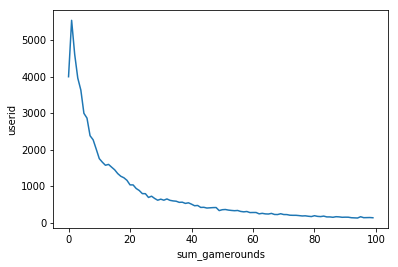

In [20]:
%matplotlib inline

plot_df = df.groupby(['sum_gamerounds'])['userid'].count()

ax = plot_df.head(n=100).plot(x='sum_gamerounds', y= 'userid')
ax.set_xlabel("sum_gamerounds")
ax.set_ylabel("userid")

In [21]:
plot_df = df.groupby([df['sum_gamerounds'] == 0]).count()
print(plot_df)

                userid  version  sum_gamerounds  retention_1  retention_7
sum_gamerounds                                                           
False            86195    86195           86195        86195        86195
True              3994     3994            3994         3994         3994


3,994 players did not play at all after having installed the game, so gave it a try, others got hooked

## 1-day retention 
An interesting metric is to see how many users came back and play the day after having installed the game

In [22]:
ret_1 = df['retention_1'].sum() / df['retention_1'].count()
print(ret_1)

0.4452095044850259


44.52% is an interesting benchmark. We do not know how many players reached gate 30 or 40 within a day of playing, however, the purpose of this exercise is just to practice AB test, so let's go to it. 

What is the retention for the control group (gate at level 30) and for the treatment group (gate at level 40) after one day of playing? 

In [23]:
C = df[df['version'] == 'gate_30']
C_ret_1 = C['retention_1'].sum() / C['retention_1'].count()
print("retention for the control group after 1 day : {:.4f}" .format(C_ret_1))

T = df[df['version'] == 'gate_40']
T_ret_1 = T['retention_1'].sum() / T['retention_1'].count()
print("retention for the treatement group after 1 day : {:.4f}" .format(T_ret_1))

retention for the control group after 1 day : 0.4482
retention for the treatement group after 1 day : 0.4423


### Bootstrap
there seems to be a slight difference, I'm going to create 1000 replica for each group and take a look at the plot to see if the difference is consistent 

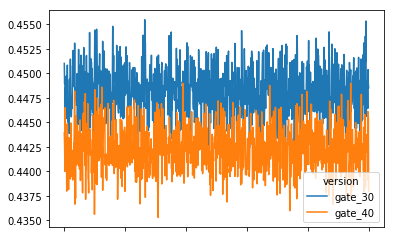

In [25]:
boot_1d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)

boot_1d.plot()

Let's take a closer look at the difference

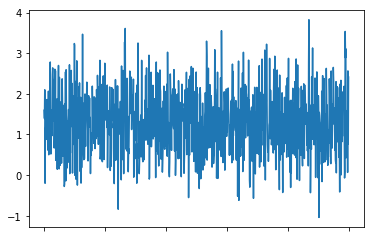

In [26]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40'])/boot_1d['gate_40'])*100
ax = boot_1d['diff'].plot()

The distribution is mostly above 0% and the most likely difference seems to be between 1% and 2%. 
The point of the AB test is to quantify what is the probablity of the difference between anove 0%? 

In [27]:
prob = (boot_1d['diff'] > 0).sum() / len(boot_1d['diff'])

print("the probabilty of the difference being above 1% is :", prob)

the probabilty of the difference being above 1% is : 0.957


## 7-days retention

In [29]:
ret_7 = df['retention_7'].sum() / df['retention_7'].count()
print(ret_7)

0.1860648194347426


Only 18.6% of the users who installed the game were still playing after a week. Let's see if the difference between control and treatment group is more pronaunced 

1.0


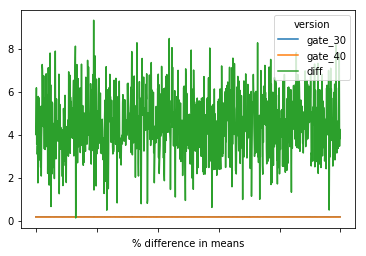

In [31]:
# create the replica
boot_7d = []
for i in range(1000):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

# from list to dataframe
boot_7d = pd.DataFrame(boot_7d)

# difference in % between treatment and control
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40'])/(boot_7d['gate_40'])*100

ax = boot_7d.plot()
ax.set_xlabel("% difference in means")

# probability that the retention is greater for the control group
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(prob)

## Conclusion
Here it is even more clear, the retention at day 7 for the control group with the gate at leave 30 is roughly between 4% and 6% higher than for the treatment group. Moreover the probablity to be so is extremeley high